# Samsung AI Challenge Baseline

## 0. Setup

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import time
from pathlib import Path
from tqdm.notebook import tqdm

import openbabel
from rdkit import Chem
from rdkit import DataStructs
from rdkit.Chem import Descriptors

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

## 1. Preprocessing

### SDF (Temp.)

In [ ]:
# SDF Load
train_sdf_path = data_path / 'train_sdf'
train_sdf_path.iterdir()
example_sdf = Chem.SDMolSupplier('./datasets/train_sdf/train_0.sdf')
for mol in example_sdf:
    print(mol.GetNumAtoms())
for path in sorted(train_sdf_path.iterdir(), key=lambda l: int(l.name[6:-4])):
    #print (path, path.name)
    pass

In [ ]:
mol = train_df.iloc[0, 1]
mol = Chem.MolFromSmiles(mol)
fp = Chem.rdmolops.PatternFingerprint(mol)
arr = np.zeros(0)
DataStructs.ConvertToNumpyArray(fp, arr)

### RDKit

In [2]:
# Data Path
data_path = Path('../datasets')
data_path.exists()

True

In [3]:
# SMILES Load
train_df = pd.read_csv(data_path / 'train.csv')
train_df.head()

,uid,SMILES,S1_energy(eV),T1_energy(eV)
0,train_0,CCC1CCCCN1C(=O)C(C)OC(=O)c1c(C)oc(-n2cccc2)c1C#N,4.6747,3.3809
1,train_1,COc1ccc(Oc2ccc(N3C(=S)NC(c4ccccn4)C3c3cc(C)n(-...,3.6617,3.4585
2,train_2,CC(=O)Nc1ccc(C(=O)[C@H](C)Sc2nnc(C3CCCCC3)o2)cc1,3.6420,3.1787
3,train_3,OC(CNC1CC1)CN1CCc2sccc2C1,4.8901,3.7847
4,train_4,CCNC(CCCC(F)(F)F)C1(OCC)CCOCC1,6.4967,6.2724


In [4]:
# Get molecular properties

mol_properties = ['MolLogP', 'ExactMolWt', 'HeavyAtomMolWt',
                  'MaxPartialCharge', 'MinPartialCharge',
                  'HeavyAtomCount', 'NHOHCount', 'NOCount',
                  'NumHAcceptors', 'NumHDonors', 'NumHeteroatoms', 'NumValenceElectrons',
                  'NumAromaticRings', 'NumSaturatedRings', 'NumAliphaticRings',
                  'NumAromaticHeterocycles', 'NumAromaticCarbocycles',
                  'RingCount', 'TPSA']

for idx, mol in enumerate(train_df.loc[:, 'SMILES']):
    mol = Chem.MolFromSmiles(mol)
    for properties in mol_properties:
        train_df.loc[idx, properties] = getattr(Descriptors, properties)(mol)

train_df.head()

,uid,SMILES,S1_energy(eV),T1_energy(eV),MolLogP,ExactMolWt,HeavyAtomMolWt,MaxPartialCharge,MinPartialCharge,HeavyAtomCount,...,NumHDonors,NumHeteroatoms,NumValenceElectrons,NumAromaticRings,NumSaturatedRings,NumAliphaticRings,NumAromaticHeterocycles,NumAromaticCarbocycles,RingCount,TPSA
0,train_0,CCC1CCCCN1C(=O)C(C)OC(=O)c1c(C)oc(-n2cccc2)c1C#N,4.6747,3.3809,3.58680,383.184506,358.248,0.343435,-0.448830,28.0,...,0.0,7.0,148.0,2.0,1.0,1.0,2.0,0.0,3.0,88.47
1,train_1,COc1ccc(Oc2ccc(N3C(=S)NC(c4ccccn4)C3c3cc(C)n(-...,3.6617,3.4585,7.82614,596.164889,567.908,0.174255,-0.505753,42.0,...,2.0,9.0,212.0,5.0,1.0,1.0,2.0,3.0,6.0,71.78
2,train_2,CC(=O)Nc1ccc(C(=O)[C@H](C)Sc2nnc(C3CCCCC3)o2)cc1,3.6420,3.1787,4.43920,373.146013,350.294,0.276797,-0.415640,26.0,...,1.0,7.0,138.0,2.0,1.0,1.0,1.0,1.0,3.0,85.09
3,train_3,OC(CNC1CC1)CN1CCc2sccc2C1,4.8901,3.7847,1.21910,252.129634,232.223,0.079101,-0.390465,17.0,...,2.0,4.0,94.0,1.0,1.0,2.0,1.0,0.0,3.0,35.50
4,train_4,CCNC(CCCC(F)(F)F)C1(OCC)CCOCC1,6.4967,6.2724,3.28280,297.191564,271.153,0.388624,-0.381223,20.0,...,1.0,6.0,120.0,0.0,1.0,1.0,0.0,0.0,1.0,30.49


In [10]:
# Only predict S1-T1 Gap
train_df['Gap'] = train_df['S1_energy(eV)'] - train_df['T1_energy(eV)']
train_df.drop(['S1_energy(eV)', 'T1_energy(eV)'], axis=1, inplace=True)
train_df = train_df.fillna(0)
train_df.head()

,uid,SMILES,MolLogP,ExactMolWt,HeavyAtomMolWt,MaxPartialCharge,MinPartialCharge,HeavyAtomCount,NHOHCount,NOCount,...,NumHeteroatoms,NumValenceElectrons,NumAromaticRings,NumSaturatedRings,NumAliphaticRings,NumAromaticHeterocycles,NumAromaticCarbocycles,RingCount,TPSA,Gap
0,train_0,CCC1CCCCN1C(=O)C(C)OC(=O)c1c(C)oc(-n2cccc2)c1C#N,3.58680,383.184506,358.248,0.343435,-0.448830,28.0,0.0,7.0,...,7.0,148.0,2.0,1.0,1.0,2.0,0.0,3.0,88.47,1.2938
1,train_1,COc1ccc(Oc2ccc(N3C(=S)NC(c4ccccn4)C3c3cc(C)n(-...,7.82614,596.164889,567.908,0.174255,-0.505753,42.0,2.0,7.0,...,9.0,212.0,5.0,1.0,1.0,2.0,3.0,6.0,71.78,0.2032
2,train_2,CC(=O)Nc1ccc(C(=O)[C@H](C)Sc2nnc(C3CCCCC3)o2)cc1,4.43920,373.146013,350.294,0.276797,-0.415640,26.0,1.0,6.0,...,7.0,138.0,2.0,1.0,1.0,1.0,1.0,3.0,85.09,0.4633
3,train_3,OC(CNC1CC1)CN1CCc2sccc2C1,1.21910,252.129634,232.223,0.079101,-0.390465,17.0,2.0,3.0,...,4.0,94.0,1.0,1.0,2.0,1.0,0.0,3.0,35.50,1.1054
4,train_4,CCNC(CCCC(F)(F)F)C1(OCC)CCOCC1,3.28280,297.191564,271.153,0.388624,-0.381223,20.0,1.0,3.0,...,6.0,120.0,0.0,1.0,1.0,0.0,0.0,1.0,30.49,0.2243


In [13]:
# View Heatmap
plt.figure(figsize=(15,15))
sns.heatmap(train_df.loc[:,'MolLogP':].corr(), linewidths=0.1, vmax=1, cmap=plt.cm.coolwarm, linecolor='white', annot=True)
plt.show()

In [181]:
from sklearn.model_selection import train_test_split
x_train, y_train = train_df.iloc[:,2:-1].values, train_df.iloc[:,-1].values.reshape(-1,1)
x_train, x_val, y_train, y_val = train_test_split(x_train, y_train)
print (x_train.shape, x_val.shape, y_train.shape, y_val.shape)

(22705, 19) (7569, 19) (22705, 1) (7569, 1)


In [184]:
class Scaler:
    def __init__(self, eps=1e-6):
        self.mean = None
        self.std = None
        self.eps = eps
    def fit(self, x):
        self.mean = np.mean(x, axis=0, keepdims=True)
        self.std = np.std(x, axis=0, keepdims=True)
    def transform(self, x):
        return (x-self.mean) / (self.std + self.eps)
sc = Scaler()
sc.fit(x_train)
x_train, x_val = sc.transform(x_train), sc.transform(x_val)

In [187]:
# Dataset / DataLoader
from torch.utils.data import TensorDataset, DataLoader
batch_size = 16
x_train, x_val = torch.FloatTensor(x_train), torch.FloatTensor(x_val)
y_train, y_val = torch.FloatTensor(y_train), torch.FloatTensor(y_val)
train_dataset = TensorDataset(x_train, y_train)
val_dataset = TensorDataset(x_val, y_val)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

## 2. Simple FNN Model Generation

In [132]:
# Simple FNN w/ 2 Fully Connected Hidden Layer

class FNN(nn.Module):
    def __init__(self, in_chans, chans=256):
        super(FNN, self).__init__()
        self.layers = nn.ModuleList([nn.Linear(in_chans, chans)])
        for _ in range(4):
            self.layers.append(nn.Linear(chans, chans//2))
            chans = chans // 2
        self.last_layer = nn.Linear(chans, 1)

    def forward(self, x):
        for layer in self.layers:
            x = F.relu(layer(x))
        return self.last_layer(x)

In [133]:
from pytorch_model_summary import summary
print(summary(FNN(in_chans=19), torch.zeros([16, 19])))

-----------------------------------------------------------------------
      Layer (type)        Output Shape         Param #     Tr. Param #
          Linear-1           [16, 256]           5,120           5,120
          Linear-2           [16, 128]          32,896          32,896
          Linear-3            [16, 64]           8,256           8,256
          Linear-4            [16, 32]           2,080           2,080
          Linear-5            [16, 16]             528             528
          Linear-6             [16, 1]              17              17
Total params: 48,897
Trainable params: 48,897
Non-trainable params: 0
-----------------------------------------------------------------------


## 3. Training

In [144]:
# Training Function
def train_epoch(model, data_loader, optimizer, scheduler, loss_type, metric_type, device):

    model.train()
    start_epoch = time.time()
    train_loss = 0.
    train_metric = 0.
    sample_num = 0

    for data in data_loader:
        inputs = data[0].to(device)
        labels = data[1].to(device)
        outputs = model(inputs)
        loss = loss_type(outputs, labels)
        metric = metric_type(outputs, labels)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        train_loss += loss.item()
        train_metric += metric.item()
        sample_num += 1
    
    scheduler.step()

    train_loss = train_loss / sample_num
    train_metric = train_metric / sample_num

    return train_loss, train_metric, time.time() - start_epoch

# Validation Function
def val_epoch(model, data_loader, loss_type, metric_type, device):

    model.eval()
    start_epoch = time.time()
    val_loss = 0.
    val_metric = 0.
    sample_num = 0
    
    with torch.no_grad():
        for data in data_loader:
            inputs = data[0].to(device)
            labels = data[1].to(device)
            outputs = model(inputs)
            loss = loss_type(outputs, labels)
            metric = metric_type(outputs, labels)
            val_loss += loss.item()
            val_metric += metric.item()
            sample_num += 1

    val_loss = val_loss / sample_num
    val_metric = val_metric / sample_num

    return val_loss, val_metric, time.time() - start_epoch

In [188]:
# Options
device = torch.device('cuda')
model = FNN(in_chans=19).to(device)
loss_type = nn.MSELoss().to(device)
metric_type = nn.L1Loss().to(device)
optimizer = optim.Adam(model.parameters(), lr=1e-3)
scheduler = optim.lr_scheduler.CosineAnnealingWarmRestarts(optimizer, T_0=10, T_mult=2)

# Early Stopping
step_count = 0
min_val_loss = np.Inf
min_val_step = 0
patience = 50
patience_step = 0
earlystop = False

# Report
train_loss_list, val_loss_list = [[], []], [[], []]
report_per_epoch = 5

In [189]:
# Train
for step in tqdm(range(70), desc='Training'):
    # Training
    train_loss, train_metric, train_time = train_epoch(model,
                                                       train_loader,
                                                       optimizer,
                                                       scheduler,
                                                       loss_type,
                                                       metric_type,
                                                       device)
    # Validation
    val_loss, val_metric, val_time = val_epoch(model,
                                               val_loader,
                                               loss_type,
                                               metric_type,
                                               device)
    # Early Stopping
    if min_val_loss > val_loss:
        min_val_loss = val_loss
        min_val_step = step_count
        patience_step = 0
        torch.save(model.state_dict(), './best_model.pt')
    else:
        patience_step += 1
        if patience_step == patience: earlystop = True
    # Step count
    step_count += 1
    # Report
    if step_count % report_per_epoch == 0:
        print("[Step {:03d}] Training MSE: {:.3f} MAE: {:.3f} ({:.1f} s) | Val MSE: {:.3f} MAE: {:.3f} ({:.1f} s) | lr: min_val_step: {:d}"
            .format(step_count, train_loss, train_metric, train_time, val_loss, val_metric, val_time, min_val_step + 1))
    # List Generation
    train_loss_list[0].append(train_loss)
    train_loss_list[1].append(train_metric)
    val_loss_list[0].append(val_loss)
    val_loss_list[1].append(val_metric)
    # Break
    if earlystop:
        print('Early Stopping!')
        break

Training:   0%|          | 0/70 [00:00<?, ?it/s]

[Step 005] Training MSE: 0.107 MAE: 0.252 (3.1 s) | Val MSE: 0.109 MAE: 0.255 (0.3 s) | lr: min_val_step: 5
[Step 010] Training MSE: 0.095 MAE: 0.236 (3.1 s) | Val MSE: 0.103 MAE: 0.244 (0.3 s) | lr: min_val_step: 10
[Step 015] Training MSE: 0.099 MAE: 0.242 (3.1 s) | Val MSE: 0.103 MAE: 0.244 (0.3 s) | lr: min_val_step: 15
[Step 020] Training MSE: 0.090 MAE: 0.229 (3.0 s) | Val MSE: 0.103 MAE: 0.245 (0.3 s) | lr: min_val_step: 15
[Step 025] Training MSE: 0.079 MAE: 0.213 (3.0 s) | Val MSE: 0.105 MAE: 0.243 (0.3 s) | lr: min_val_step: 21
[Step 030] Training MSE: 0.072 MAE: 0.204 (3.0 s) | Val MSE: 0.105 MAE: 0.243 (0.3 s) | lr: min_val_step: 21
[Step 035] Training MSE: 0.087 MAE: 0.224 (3.1 s) | Val MSE: 0.107 MAE: 0.245 (0.3 s) | lr: min_val_step: 21
[Step 040] Training MSE: 0.082 MAE: 0.217 (3.0 s) | Val MSE: 0.107 MAE: 0.247 (0.3 s) | lr: min_val_step: 21
[Step 045] Training MSE: 0.072 MAE: 0.203 (3.1 s) | Val MSE: 0.110 MAE: 0.250 (0.3 s) | lr: min_val_step: 21
[Step 050] Training 

In [190]:
# Load best model
model.load_state_dict(torch.load('./best_model.pt'))

<All keys matched successfully>

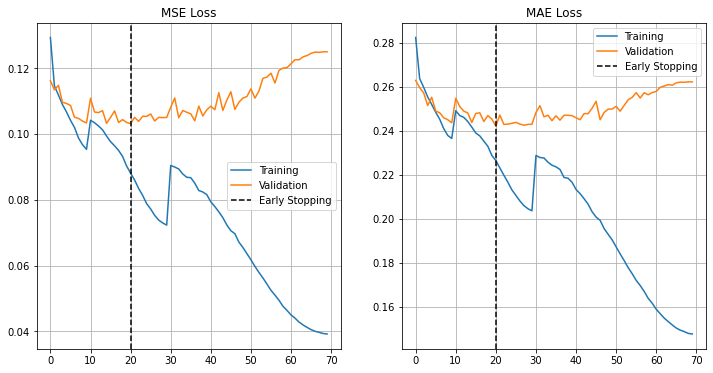

In [191]:
#Learning Curve

fig, axes = plt.figure(figsize=(12,6)), []
label = ['MSE Loss', 'MAE Loss']

for i in range(2):
    axes.append(fig.add_subplot(1,2,i+1))
    axes[-1].plot(train_loss_list[i], label='Training')
    axes[-1].plot(val_loss_list[i], label='Validation')
    axes[-1].axvline(min_val_step, linestyle='--', color='black', label='Early Stopping')
    axes[-1].set_title(label[i])
    axes[-1].grid(True)
    axes[-1].legend()

plt.show()

In [ ]:
# Visualization

fig, axes = plt.figure(figsize=(12,6)), []





## 4. Submission

In [224]:
# DataLoader Generation
test_df = pd.read_csv(data_path / 'test.csv')

for idx, mol in enumerate(test_df.loc[:, 'SMILES']):
    mol = Chem.MolFromSmiles(mol)
    for properties in mol_properties:
        test_df.loc[idx, properties] = getattr(Descriptors, properties)(mol)
        
test_df.replace(np.inf, 0, inplace=True)
test_df = test_df.fillna(0)
test_df.head()

,uid,SMILES,MolLogP,ExactMolWt,HeavyAtomMolWt,MaxPartialCharge,MinPartialCharge,HeavyAtomCount,NHOHCount,NOCount,...,NumHDonors,NumHeteroatoms,NumValenceElectrons,NumAromaticRings,NumSaturatedRings,NumAliphaticRings,NumAromaticHeterocycles,NumAromaticCarbocycles,RingCount,TPSA
0,test_0,COc1ccc(S(=O)(=O)NC2CCN(C3CCCCC3)CC2)c(C)c1C,3.38744,380.213364,348.298,0.240594,-0.496477,26.0,1.0,5.0,...,1.0,6.0,146.0,1.0,2.0,2.0,0.0,1.0,3.0,58.64
1,test_1,CC(CCCC1CCC2C3=C(CC[C@]12C)[C@@]1(C)CC[C@H](C)...,8.55900,428.401816,376.329,0.061668,-0.390194,31.0,1.0,1.0,...,1.0,1.0,178.0,0.0,2.0,4.0,0.0,0.0,4.0,20.23
2,test_2,C[C@@H]1C[C@@H]1c1ccc2c(c1)c(-c1ccc[nH]c1=O)c(...,4.13590,511.137734,488.366,0.281532,-0.331319,36.0,2.0,7.0,...,2.0,10.0,186.0,4.0,1.0,1.0,2.0,2.0,5.0,101.03
3,test_3,CCCn1c(=O)c2ccccc2n2c(SCC(=O)NC(Cc3ccccc3)c3cc...,4.64650,497.188546,470.408,0.262276,-0.348235,36.0,1.0,7.0,...,1.0,8.0,182.0,5.0,0.0,0.0,2.0,3.0,5.0,81.29
4,test_4,CC(C)CN(C[C@@H](O)[C@H](Cc1ccccc1)NC(=O)OCc1cn...,3.88030,589.148732,558.517,0.407315,-0.443765,39.0,4.0,10.0,...,3.0,13.0,208.0,4.0,0.0,0.0,2.0,2.0,4.0,147.74


In [225]:
x_test = test_df.iloc[:,2:].values
x_test = sc.transform(x_test)
x_test = torch.FloatTensor(x_test)
test_dataset = TensorDataset(x_test)
test_loader = DataLoader(test_dataset, batch_size=1, shuffle=False)

In [226]:
# Submission
sub_df = pd.DataFrame()
for i, data in enumerate(test_loader):
    inputs = data[0].to(device)
    outputs = model(inputs)
    sub_df.loc[i, 'uid'] = 'test_{}'.format(i)
    sub_df.loc[i, 'ST1_GAP(eV)'] = outputs.item()
sub_df.to_csv('./submission.csv', index=False)